In [1]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import seaborn as sns
import arviz as az
import corner
import time

In [2]:
data=pd.read_csv("UK-HIV-AIDS.csv",header=None)

In [3]:
y_obs_tmp=data[[1,2]]
y_obs=y_obs_tmp.to_numpy()

In [4]:
#az.style.use("arviz-darkgrid")

NumIter = 10000
burnin  = 5000

save_results_to = 'UK_hypothTest/'

times = np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
N=len(times)
small_times = np.linspace(0, N-1 ,10*N+1)


pred_days  = N+1
times_pred = np.linspace(0, pred_days,pred_days +1 ) 
times_pred_small = np.linspace(0, pred_days,(pred_days+1)*10 +1 ) 

pop = 66440000         # Population 

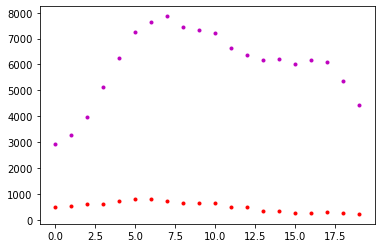

In [5]:
fig0= plt.figure()
plt.plot(times, y_obs[:,0],'m.', times, y_obs[:,1],'r.')
#plt.show()
plt.savefig( save_results_to + 'HIV-AIDS_cases.eps')

In [6]:
mydata = {}
mydata['n_obs']       = len(times)
mydata['n_small']     = len(small_times)
mydata['n_small_pred']= len(times_pred_small)
mydata['n_theta']     = 6
mydata['n_difeq']     = 3
mydata['n_pop']       = pop
mydata['y']           = y_obs
mydata['t0']          = -0.000001
mydata['n_fake']      = len(times_pred)
mydata['fake_ts']     = times_pred_small
mydata['tsm']         = small_times
mydata['ts']          = times

In [7]:
beta_exp = 5.
R0_stan = 'exponential({beta})'.format(beta=beta_exp)


Alpha = 1.
Beta  = 2.
beta_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 2.
sigma_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 2.
Karga1_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 2.
Karga2_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)



Alpha = 1.
Beta  = 2.
xi1_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)



Alpha = 1.
Beta  = 2.
xi2_stan =  'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)

In [8]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0115;
  real nu= 0.0073;

//  real sigma  = 0.125;

  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  real xi1    = theta[5];
  real xi2    = theta[6];  
  
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{
  
//  real<lower =  0, upper = 3> beta ;
  real<lower =  1> R0 ;   
  real<lower =  0, upper = 3> sigma ;
  real<lower =  0, upper = 1.> Karga1 ;
  real<lower =  0, upper = 1.> Karga2 ;
  real<lower =  0, upper = 1e-2> xi1 ;
  real<lower =  0, upper = 1> xi2 ;
 
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real beta = R0 * (sigma + 0.0073);   


  
  S0 = 0.999995106;
  I0 = 0.000003263;
  A0 = 0.000001631;

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;
  theta[5] = xi1;
  theta[6] = xi2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt=1./(10*n_obs);

  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ gamma(1, 2);
  sigma    ~ gamma(1, 2);
  Karga1   ~ gamma(1, 2);
  Karga2   ~ gamma(1, 2);
  xi1      ~ gamma(1, 2);
  xi2      ~ gamma(1, 2);
  R0       ~ exponential(5); 

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);;
  y[i , 2] ~ poisson(rhho2[i]);;
  }}
 
  }}
  
  generated quantities {{

  real nu= 0.0073;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xi1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xi2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  }}
""".format(
        R0     =R0_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan,
        xi1    =xi1_stan,
        xi2    =xi2_stan    
        )

In [9]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e4313461289c87434cff5fd88c328348 NOW.


--- 30.815854787826538 seconds ---


In [10]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 1826.6466326713562 seconds ---


In [11]:
varnames = ["beta", "sigma", "Karga1", "Karga2","xi1","xi2","R0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

In [12]:
df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()

In [13]:
fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,0.715978,0.102752,0.178790,0.317202,0.769870,0.790039,0.805904,0.833939,3.027638,10.246718
sigma,0.700485,0.113160,0.196821,0.244772,0.762457,0.782621,0.798472,0.826527,3.025261,11.133069
Karga1,0.071340,0.009950,0.017253,0.032699,0.077843,0.078806,0.079534,0.080832,3.006712,21.070025
Karga2,0.104593,0.125732,0.217830,0.007011,0.007139,0.007219,0.007322,0.602225,3.001553,81.642464
xi1,0.006821,0.000822,0.001433,0.005826,0.006079,0.006232,0.006437,0.010000,3.040999,8.422225
xi2,0.043744,0.056297,0.097688,0.000004,0.000044,0.000113,0.000285,0.275238,3.010947,34.081656
R0,1.030600,0.038821,0.072213,1.000004,1.000054,1.000143,1.000361,1.262920,3.460122,5.473283


In [14]:
# with open('Table.tex','w') as tf:
#      tf.write(df_summary.to_latex())

In [15]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive="fake",
    observed_data=["y"],
)

data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

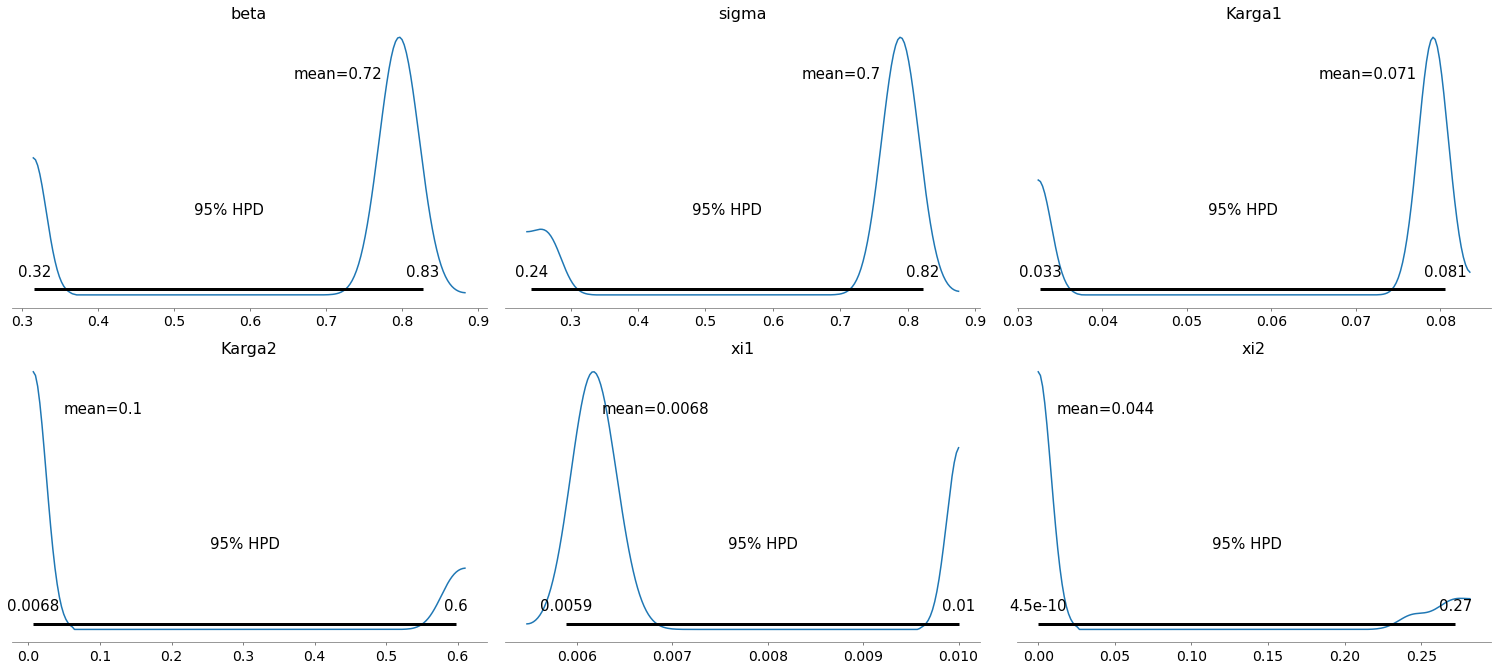

In [16]:
varnames = ["beta", "sigma", "Karga1", "Karga2","xi1","xi2"]
az.plot_posterior(data,var_names=varnames,credible_interval=0.95);

<Figure size 432x288 with 0 Axes>

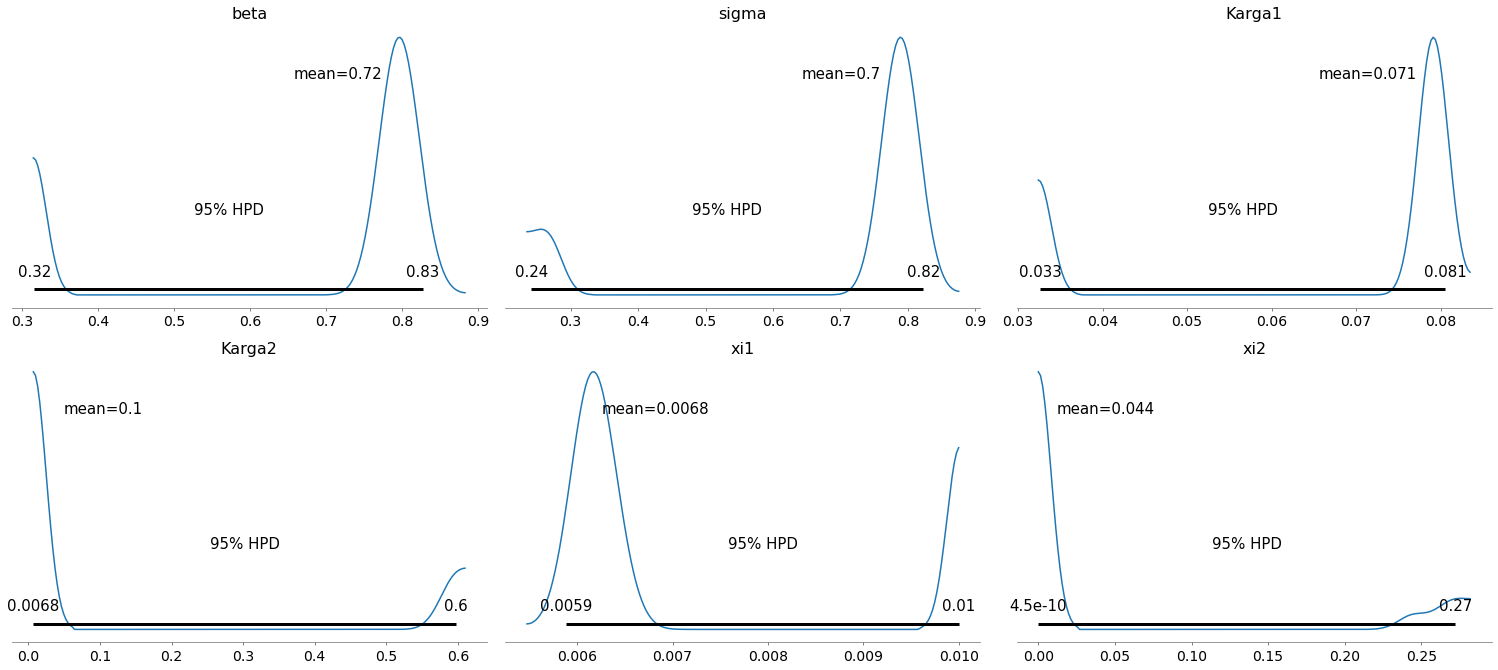

In [17]:
fig =plt.figure()
az.plot_posterior(data,var_names=varnames,credible_interval=0.95);
plt.savefig(save_results_to + 'credibleIntervalsAll.png')

/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument

<Figure size 432x288 with 0 Axes>

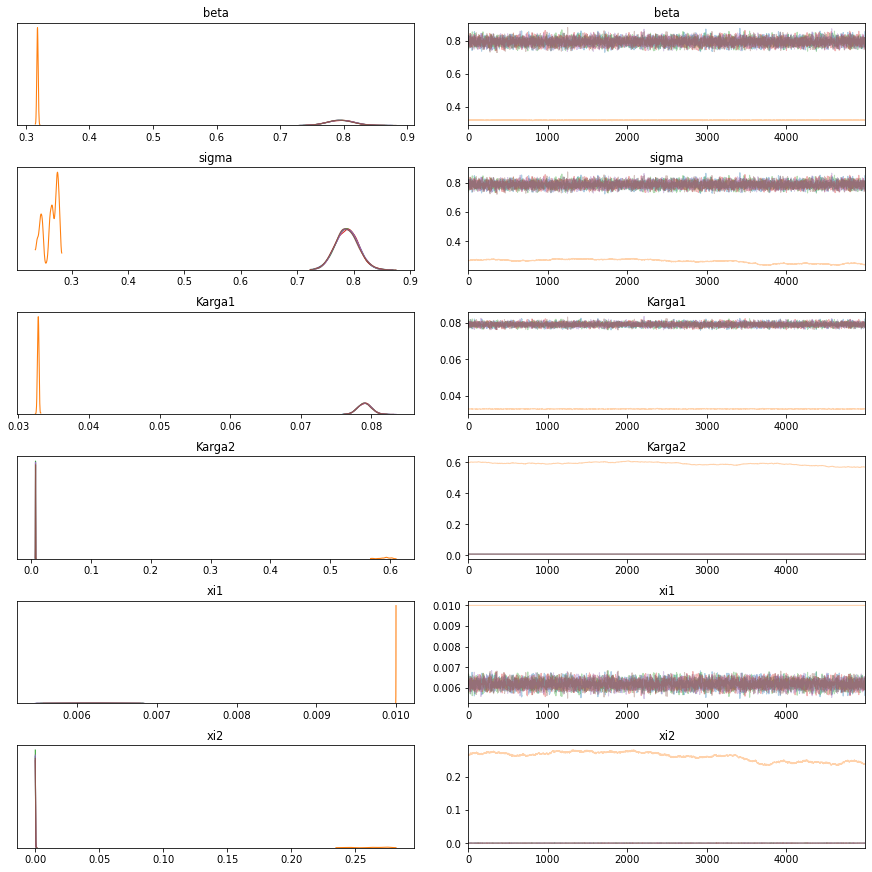

In [18]:
inference_data = az.from_pystan(fit)
plt.figure()
az.plot_trace(inference_data,var_names= varnames)
plt.savefig(save_results_to +'TraceAll_UK.pdf')

In [19]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

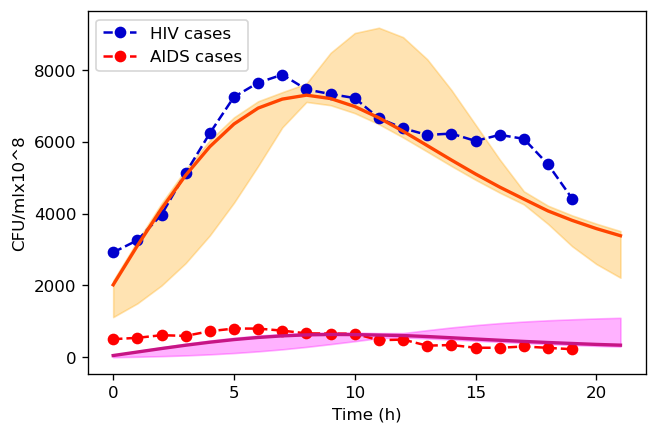

In [20]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='mediumblue',label="HIV cases")
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='red',label="AIDS cases")
ax.plot(times_pred,median_ppc[:,0], color='orangered', lw=2)
ax.plot(times_pred,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.fill_between(times_pred,CriL_ppc[:,0],CriU_ppc[:,0], color='orange', alpha=0.3)
ax.fill_between(times_pred,CriL_ppc[:,1],CriU_ppc[:,1], color='magenta', alpha=0.3)
ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
ax.set_ylabel('CFU/mlx10^8')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc="upper left")  # Add a legend.
ax.figure.savefig(save_results_to +'PredBands.pdf')

In [21]:
#varnames = ["beta_s", "beta_r",  "delta", "Karga","s0","i0"]
pystan_trace = [fit_dict['beta'], fit_dict['sigma'], fit_dict['Karga1'],
                fit_dict['Karga2'],fit_dict['xi1'],fit_dict['xi2']]

In [22]:
trace=np.array(pystan_trace)
trace_df = pd.DataFrame(pystan_trace) 
map=np.median(trace,axis=1)
range = np.array([(0.5*x,1.5*x) for x in map])

<Figure size 432x288 with 0 Axes>

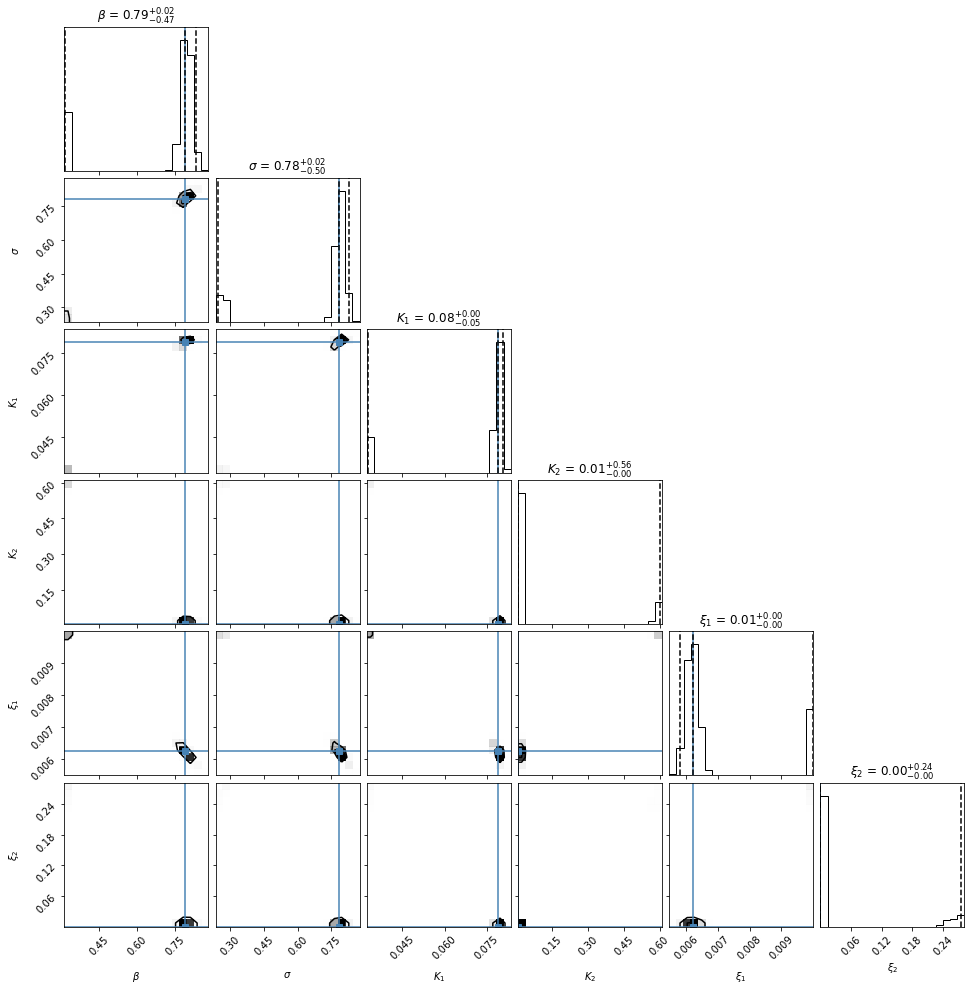

In [23]:
varnames=[r"$\beta$", r"$\sigma$" ,r"$K_{1}$" ,r"$K_{2}$",r"$\xi_{1}$",r"$\xi_{2}$"]
range = np.array([(0.1*x,1.9*x) for x in map])
plt.figure()
corner.corner(trace_df.T,show_titles=True,labels=varnames,truths=map,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975])
plt.savefig(save_results_to +'corner2.pdf')

In [24]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

In [25]:
print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_H0 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_H0 =')
print(J_H0)

Residuals of HIV cases =
3328.364162768251
Residuals of AIDS cases =
1073.0615080227228
J_H0 =
4401.4256707909735


In [26]:
R0_low  = 0
R0_high = 1
R0_stan = 'uniform({mu}, {sd})'.format(mu=R0_low, sd=R0_high)


Alpha = 1.
Beta  = 2.
beta_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 2.
sigma_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 2.
Karga1_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 2.
Karga2_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)



Alpha = 1.
Beta  = 2.
xi1_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 2.
xi2_stan =  'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)

In [27]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0115;
  real nu= 0.0073;

//  real sigma  = 0.125;

  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  real xi1    = theta[5];
  real xi2    = theta[6];  
  
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{
  
//  real<lower =  0, upper = 3> beta ;
  real<lower =  0, upper = 1.> R0 ;   
  real<lower =  0, upper = 3> sigma ;
  real<lower =  0, upper = 1.> Karga1 ;
  real<lower =  0, upper = 1.> Karga2 ;
  real<lower =  0, upper = 1e-2> xi1 ;
  real<lower =  0, upper = 1> xi2 ;
 
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real beta = R0 * (sigma + 0.0073);   


  
  S0 = 0.999995106;
  I0 = 0.000003263;
  A0 = 0.000001631;

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;
  theta[5] = xi1;
  theta[6] = xi2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt=1./(10*n_obs);

  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ gamma(1, 2);
  sigma    ~ gamma(1, 2);
  Karga1   ~ gamma(1, 2);
  Karga2   ~ gamma(1, 2);
  xi1      ~ gamma(1, 2);
  xi2      ~ gamma(1, 2);
  R0       ~ uniform(0.0, 1.0 );  

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);;
  y[i , 2] ~ poisson(rhho2[i]);;
  }}
 
  }}
  
  generated quantities {{

  real nu= 0.0073;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xi1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xi2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  }}
""".format(
        R0     =R0_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan,
        xi1    =xi1_stan,
        xi2    =xi2_stan    
        )

In [28]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5554394d8d17d6d67ef0551817222a64 NOW.


--- 29.142910957336426 seconds ---


In [29]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 940.3885643482208 seconds ---


In [30]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

In [31]:
df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

In [32]:
fit_dict= fit.extract()
fit_df = fit.to_dataframe()

In [33]:
fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.855475,0.001050,0.092421,1.687178,1.791084,1.851755,1.916401,2.044959,7750.207509,1.001074
sigma,2.291266,0.003123,0.209303,1.984277,2.141863,2.252108,2.402166,2.816825,4492.087306,1.001202
Karga1,0.167276,0.000055,0.004731,0.158393,0.163967,0.167174,0.170447,0.176845,7295.370994,1.001036
Karga2,0.014700,0.000005,0.000423,0.013901,0.014408,0.014688,0.014982,0.015558,7569.626197,1.000953
R0,0.811860,0.000877,0.060825,0.660751,0.777313,0.827506,0.859987,0.884974,4814.598137,1.001341


In [34]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [35]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

In [36]:
print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
#J_H1 = ( 1/len(y_obs[:,0]) ) *(euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1]) )
J_H1 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_H1 =')
print(J_H1)

Residuals of HIV cases =
3415.6419601591733
Residuals of AIDS cases =
878.0455569046517
J_H1 =
4293.687517063825


In [38]:
#U=( J_H1-J_H0 )/J_H1
U=-( len(y_obs[:,0]) ) *( J_H1-J_H0 )/J_H1
U

0.5018444090259446